In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
project_root = Path.cwd().parent.parent  # Assuming notebook is in experiments/notebooks/
sys.path.insert(0, str(project_root))
print(sys.path)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from experiments.analysis_utils.data_processing import read_directory
from experiments.analysis_utils.visualization import plot_reaction_speed_distribution, plot_token_distribution
from specs.dual_governance.state import State

['/home/rotsker/PycharmProjects/dg-research-revision', '/home/rotsker/miniconda3/envs/radCAD/lib/python312.zip', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12/lib-dynload', '', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12/site-packages']


In [2]:
path_to_runs = Path("../../results/simulations/rage_quit_loop/")
proposal_df_full, start_data_df_full, timestep_data_df_full = read_directory(path_to_runs.resolve(), pass_directory_name=True)
timestep_data_df_full['run_id_str'] = timestep_data_df_full['run_id'].astype(str)

In [3]:
# sns.lineplot(data=timestep_data_df_full, x='timestep', y='actors_total_locked', hue='run_id')

In [4]:
start_data_df_full

,seed,first_seal_rage_quit_support,second_seal_rage_quit_support,attacker_funds,simulation_hash,determining_factor,lido_exit_share,churn_rate,timedelta_tick,n_actors,...,HonestActor,SingleAttacker,CoordinatedAttacker,Hacker,SingleDefender,CoordinatedDefender,directory_name,run_id,initial_total_balance,attacker_share
0,1888,0.01,0.1,1000000,134f4a176b5f7ce0d91bf74e83458ec9de016ae53ae999...,0,0.3,14,0 days 03:00:00,1986,...,1984,0,2,0,0,0,batch_9ef9cf52d4fe5e6f36f4e54776e96202d1d690c5...,0,1.092372e+07,0.091544
1,1888,0.01,0.1,2000000,390a864dd807e510013036bc06d95164dbdfe2ecb2c0ad...,0,0.3,14,0 days 03:00:00,1986,...,1984,0,2,0,0,0,batch_9ef9cf52d4fe5e6f36f4e54776e96202d1d690c5...,1,1.292372e+07,0.154754
2,1888,0.01,0.1,1000000,79201e4642390e22b3ab814c063b78f92acd7dc4bf0e52...,0,0.7,14,0 days 03:00:00,1986,...,1984,0,2,0,0,0,batch_9ef9cf52d4fe5e6f36f4e54776e96202d1d690c5...,2,1.092372e+07,0.091544
3,1888,0.01,0.1,1000000,da2848a9634df607503349d9dfbca666c1caeda68fd342...,0,0.5,14,0 days 03:00:00,1986,...,1984,0,2,0,0,0,batch_9ef9cf52d4fe5e6f36f4e54776e96202d1d690c5...,3,1.092372e+07,0.091544
4,1888,0.01,0.1,2000000,42b28ed156706bbb6686cec545df234482ff4302d157e0...,0,0.5,14,0 days 03:00:00,1986,...,1984,0,2,0,0,0,batch_9ef9cf52d4fe5e6f36f4e54776e96202d1d690c5...,4,1.292372e+07,0.154754
5,1888,0.01,0.1,3000000,ccbd3cecef2c2c66f178dd76f528f866ed8f995c44e1fd...,0,0.3,14,0 days 03:00:00,1986,...,1984,0,2,0,0,0,batch_9ef9cf52d4fe5e6f36f4e54776e96202d1d690c5...,5,1.492372e+07,0.201022
6,1888,0.01,0.1,2000000,7c5200511a6f771f4f47e765c29f668a4279b019e8dbe9...,0,0.7,14,0 days 03:00:00,1986,...,1984,0,2,0,0,0,batch_9ef9cf52d4fe5e6f36f4e54776e96202d1d690c5...,6,1.292372e+07,0.154754
7,1888,0.01,0.1,3000000,7477bc09e2b83614507787a0406d341c49276af5513f44...,0,0.5,14,0 days 03:00:00,1986,...,1984,0,2,0,0,0,batch_9ef9cf52d4fe5e6f36f4e54776e96202d1d690c5...,7,1.492372e+07,0.201022
8,1888,0.01,0.1,3000000,5d434c238bfb9148315e1cbfdf5e04cf61d5b1d88ce82d...,0,0.7,14,0 days 03:00:00,1986,...,1984,0,2,0,0,0,batch_9ef9cf52d4fe5e6f36f4e54776e96202d1d690c5...,8,1.492372e+07,0.201022


In [5]:
timestep_data_df_full_with_params = timestep_data_df_full.merge(start_data_df_full, on='run_id')

In [6]:
state_timesteps_df = timestep_data_df_full.groupby(['run_id', 'dg_state_name']).size().unstack(fill_value=0)
state_timesteps_df *= 3 / 24
print('Days in each state for each run')
state_timesteps_df


Days in each state for each run


dg_state_name,Normal,RageQuit,VetoCooldown,VetoSignalling
run_id,,,,
0,271.750,43.000,0.25,45.000
1,89.375,134.625,0.75,135.250
2,292.750,22.000,0.25,45.000
3,286.750,28.000,0.25,45.000
4,136.375,87.625,0.75,135.250
5,0.625,178.250,0.75,180.375
6,156.375,67.625,0.75,135.250
7,52.375,126.250,1.00,180.375
8,80.375,98.250,1.00,180.375


In [7]:
def count_ragequit_episodes(df):
    # Initialize a list to store the results
    results = []

    # Group by 'run_id'
    for run_id, group in df.groupby('run_id'):
        # Reset index for the group
        group = group.reset_index(drop=True)
        
        # Initialize variables to track episodes
        in_episode = False
        episode_count = 0

        # Iterate over the rows in the group
        for index, row in group.iterrows():
            if row['dg_state_name'] == 'RageQuit':
                if not in_episode:
                    # Start of a new episode
                    in_episode = True
                    episode_count += 1
            else:
                # End of an episode
                in_episode = False

        # Append the result for this run_id
        results.append({'run_id': run_id, 'ragequit_episodes': episode_count})

    # Convert results to a DataFrame
    return pd.DataFrame(results)

# Apply the function to your DataFrame
ragequit_episodes_df = count_ragequit_episodes(timestep_data_df_full)

# Display the result
print(ragequit_episodes_df)

   run_id  ragequit_episodes
0       0                  1
1       1                  3
2       2                  1
3       3                  1
4       4                  3
5       5                  4
6       6                  3
7       7                  4
8       8                  4


In [8]:
print('Days in each state for each run, number of RageQuit events')
state_timesteps_df.merge(ragequit_episodes_df, on='run_id').merge(start_data_df_full[['run_id', 'attacker_funds', 'lido_exit_share']], on='run_id').set_index(['attacker_funds', 'lido_exit_share']).sort_index()

Days in each state for each run, number of RageQuit events


run_id   Normal  RageQuit  VetoCooldown  \
attacker_funds lido_exit_share                                            
1000000        0.3                   0  271.750    43.000          0.25   
               0.5                   3  286.750    28.000          0.25   
               0.7                   2  292.750    22.000          0.25   
2000000        0.3                   1   89.375   134.625          0.75   
               0.5                   4  136.375    87.625          0.75   
               0.7                   6  156.375    67.625          0.75   
3000000        0.3                   5    0.625   178.250          0.75   
               0.5                   7   52.375   126.250          1.00   
               0.7                   8   80.375    98.250          1.00   

                                VetoSignalling  ragequit_episodes  
attacker_funds lido_exit_share                                     
1000000        0.3                      45.000                  1  
               0.5                      45.000                  1  
               0.7                      45.000                  1  
2000000        0.3                     135.250                  3  
               0.5                     135.250                  3  
               0.7                     135.250                  3  
3000000        0.3                     180.375                  4  
               0.5                     180.375                  4  
               0.7                     180.375                  4

In [9]:
import pandas as pd

def calculate_state_durations(df):
    # Initialize a list to store the results
    results = []

    # Group by 'run_id'
    for run_id, group in df.groupby('run_id'):
        # Reset index for the group
        group = group.reset_index(drop=True)
        
        # Initialize variables to track state durations
        current_state = None
        state_duration = 0

        # Iterate over the rows in the group
        for index, row in group.iterrows():
            if row['dg_state_name'] == current_state:
                # Continue the current state
                state_duration += 1
            else:
                # If a state change occurs, record the previous state duration
                if current_state is not None:
                    results.append({
                        'run_id': run_id,
                        'state': current_state,
                        'duration': state_duration
                    })
                # Start a new state
                current_state = row['dg_state_name']
                state_duration = 1

        # Append the last state duration for the group
        if current_state is not None:
            results.append({
                'run_id': run_id,
                'state': current_state,
                'duration': state_duration
            })

    # Convert results to a DataFrame
    return pd.DataFrame(results)

# Apply the function to your DataFrame
state_durations_df = calculate_state_durations(timestep_data_df_full)

state_durations_df['duration_days'] = state_durations_df['duration'] * 3 / 24

# Display the result
print('Example run with constant RageQuit Loop, where attackers have 300_000 stETH')
state_durations_df[state_durations_df['run_id'] == 5]

Example run with constant RageQuit Loop, where attackers have 300_000 stETH


,run_id,state,duration,duration_days
37,5,Normal,5,0.625
38,5,VetoSignalling,360,45.000
39,5,RageQuit,443,55.375
40,5,VetoCooldown,2,0.250
41,5,VetoSignalling,361,45.125
42,5,RageQuit,405,50.625
43,5,VetoCooldown,2,0.250
44,5,VetoSignalling,361,45.125
45,5,RageQuit,373,46.625
46,5,VetoCooldown,2,0.250


In case of 300_000 stETH, RageQuit Loop can continue indefinitely


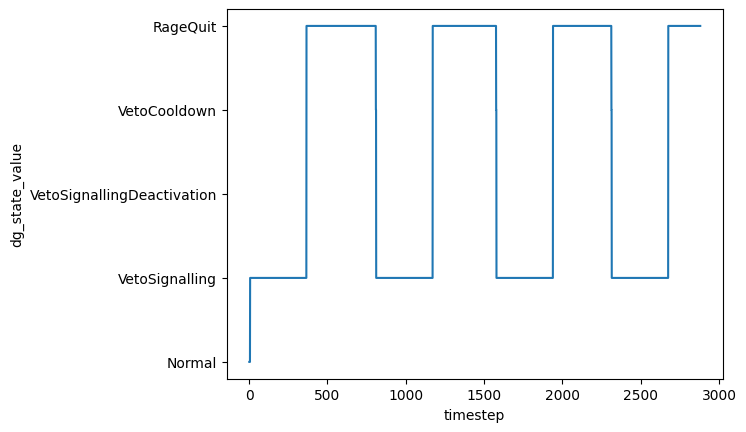

In [10]:
print('In case of 300_000 stETH, RageQuit Loop can continue indefinitely')
sns.lineplot(data=timestep_data_df_full[timestep_data_df_full['run_id'] == 5], x='timestep', y='dg_state_value')
plt.yticks([1,2,3,4,5])
from matplotlib.ticker import FuncFormatter
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{State(x).name}'))